## **Import librairies**

In [2]:
# importation des differentes librairies
from sklearn import preprocessing
from sklearn.preprocessing import normalize, StandardScaler
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from sklearn.svm          import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics      import f1_score, recall_score, accuracy_score, precision_score

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.utils import gen_even_slices

pd.set_option("display.max_columns", 999)

## **Load data**

In [3]:
# Load data

# curl -o https://drive.google.com/file/d/1hAQvu2Z5xo5sdJOgxOP704bnnMY7hlbV/view?usp=drive_link

file_dataset = f"C:/Users/georg/Desktop/Hec/Hiver 2024/Ma prise de notes/4- ML 1/Projet/Dataset/" 
file = "flights_sample_3m.csv"
path_dir = f"{file_dataset}/{file}"

df = pd.read_csv(path_dir)

display(df.head(3))

,FL_DATE,AIRLINE,AIRLINE_DOT,AIRLINE_CODE,DOT_CODE,FL_NUMBER,ORIGIN,ORIGIN_CITY,DEST,DEST_CITY,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,CANCELLATION_CODE,DIVERTED,CRS_ELAPSED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,DELAY_DUE_CARRIER,DELAY_DUE_WEATHER,DELAY_DUE_NAS,DELAY_DUE_SECURITY,DELAY_DUE_LATE_AIRCRAFT
0,2019-01-09,United Air Lines Inc.,United Air Lines Inc.: UA,UA,19977,1562,FLL,"Fort Lauderdale, FL",EWR,"Newark, NJ",1155,1151.0,-4.0,19.0,1210.0,1443.0,4.0,1501,1447.0,-14.0,0.0,NaN,0.0,186.0,176.0,153.0,1065.0,NaN,NaN,NaN,NaN,NaN
1,2022-11-19,Delta Air Lines Inc.,Delta Air Lines Inc.: DL,DL,19790,1149,MSP,"Minneapolis, MN",SEA,"Seattle, WA",2120,2114.0,-6.0,9.0,2123.0,2232.0,38.0,2315,2310.0,-5.0,0.0,NaN,0.0,235.0,236.0,189.0,1399.0,NaN,NaN,NaN,NaN,NaN
2,2022-07-22,United Air Lines Inc.,United Air Lines Inc.: UA,UA,19977,459,DEN,"Denver, CO",MSP,"Minneapolis, MN",954,1000.0,6.0,20.0,1020.0,1247.0,5.0,1252,1252.0,0.0,0.0,NaN,0.0,118.0,112.0,87.0,680.0,NaN,NaN,NaN,NaN,NaN


<Axes: xlabel='Index', ylabel='Hour delay'>

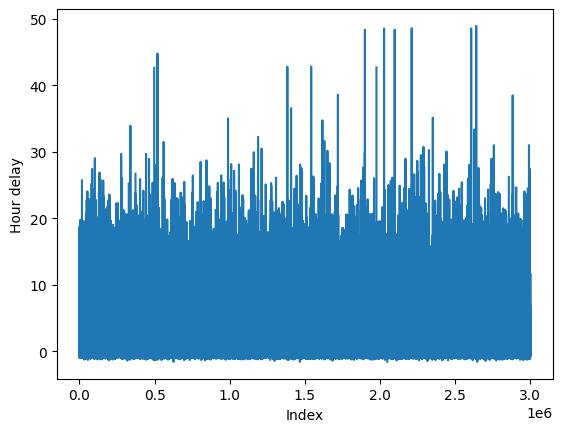

In [4]:
(df['ARR_DELAY']/60).plot( xlabel= 'Index', ylabel= 'Hour delay' )

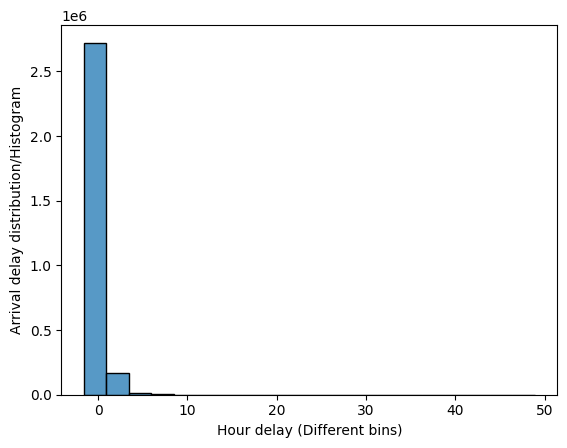

In [5]:
sns.histplot(df['ARR_DELAY']/60, bins=20) # , kde=True
plt.ylabel('Arrival delay distribution/Histogram')
plt.xlabel('Hour delay (Different bins)')
plt.show()

## **Baseline**

In [6]:
## Transformation of "CANCELLED" variable to make the cancellation as thousands hours delayed = 100.000 min

mask = df["CANCELLED"] == 1.0
df.loc[ mask , 'ARR_DELAY'] = 100000

display(df[mask].head(2))

,FL_DATE,AIRLINE,AIRLINE_DOT,AIRLINE_CODE,DOT_CODE,FL_NUMBER,ORIGIN,ORIGIN_CITY,DEST,DEST_CITY,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,CANCELLATION_CODE,DIVERTED,CRS_ELAPSED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,DELAY_DUE_CARRIER,DELAY_DUE_WEATHER,DELAY_DUE_NAS,DELAY_DUE_SECURITY,DELAY_DUE_LATE_AIRCRAFT
14,2020-04-07,Southwest Airlines Co.,Southwest Airlines Co.: WN,WN,19393,687,SJC,"San Jose, CA",LAX,"Los Angeles, CA",2155,NaN,NaN,NaN,NaN,NaN,NaN,2315,NaN,100000.0,1.0,D,0.0,80.0,NaN,NaN,308.0,NaN,NaN,NaN,NaN,NaN
45,2022-01-02,Republic Airline,Republic Airline: YX,YX,20452,3467,ORD,"Chicago, IL",DCA,"Washington, DC",1935,NaN,NaN,NaN,NaN,NaN,NaN,2241,NaN,100000.0,1.0,B,0.0,126.0,NaN,NaN,612.0,NaN,NaN,NaN,NaN,NaN


In [7]:
# Separating date into month and days values

df['date_column'] = pd.to_datetime(df['FL_DATE'])

df['month'] = df['date_column'].dt.month
df['day'] = df['date_column'].dt.day

In [8]:
# Sepearating of take-off and landing times

# Bins. Note that the 'Evening tags' covers flights from 9pm to 1am
bins = [0, 100, 500, 800, 1200, 1500, 1800, 2100, 2400]
labels = ['Evening 00-01', 'Night 01-05', 'Early Morning 05-08', 'Late Morning 08-12', 'Early Afternoon 12-15', 'Late Afternoon 18-21', 'Early Evening 21-00', 'Evening 00-01']
df['DEP_TIME_BIN'] = pd.cut(df['CRS_DEP_TIME'], bins=bins, labels=labels, ordered=False)
df['ARR_TIME_BIN'] = pd.cut(df['CRS_ARR_TIME'], bins=bins, labels=labels, ordered=False)

In [9]:
# Removing useless columns

df = df.drop(columns=['FL_DATE', 'CRS_DEP_TIME', 'DEP_TIME', 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_TIME_BIN' , 'DISTANCE' ,'DIVERTED' ,'CANCELLATION_CODE', 'CANCELLED', 'DELAY_DUE_CARRIER', 'DEP_DELAY' , 'DELAY_DUE_WEATHER', 'DELAY_DUE_NAS', 'DELAY_DUE_SECURITY', 'DELAY_DUE_LATE_AIRCRAFT', 'AIRLINE_DOT', 'DOT_CODE', 'FL_NUMBER', 'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN', 'CRS_ELAPSED_TIME', 'ELAPSED_TIME', 'AIR_TIME',  'date_column'])

In [10]:
# drop Nan value

df.dropna(subset=['ARR_DELAY'], inplace=True)

In [11]:
# # Time of arrival (HH) extraction

# df['HOUR_SPLIT_DEP_CRS'] = df['CRS_DEP_TIME'].apply(
#     lambda x: int(str(x)[:1]) if len(str(x)) <= 3 else int(str(x)[:2])
#     ) # Then should be One hot encoded

In [12]:
# discritizing of arrival delays (THE NEW OUTPUT !!!)  - Class

bins = [-np.inf, -0.9999, 3 , 50 , np.inf]
labels = ['Early', 'Very Good', 'Bad', 'Cancelled']
discritizer = preprocessing.FunctionTransformer(
             pd.cut, kw_args={'bins': bins, 'labels': labels, 'retbins': False}
             )
df['ARR_TYPE_DELAY'] = discritizer.fit_transform(df['ARR_DELAY']/60) # conversion in hour

In [13]:
## Output Analysis
print(f"The number of occurrences of different classes :\n{df['ARR_TYPE_DELAY'].value_counts()} \n\nwhich means in %:\n{(df['ARR_TYPE_DELAY'].value_counts())/len(df)*100} ")


The number of occurrences of different classes :
ARR_TYPE_DELAY
Very Good    2880886
Cancelled      79140
Bad            32263
Early            653
Name: count, dtype: int64 

which means in %:
ARR_TYPE_DELAY
Very Good    96.255992
Cancelled     2.644221
Bad           1.077969
Early         0.021818
Name: count, dtype: float64 


In [14]:
df.head(2)

,AIRLINE,AIRLINE_CODE,ORIGIN,ORIGIN_CITY,DEST,DEST_CITY,ARR_DELAY,month,day,DEP_TIME_BIN,ARR_TYPE_DELAY
0,United Air Lines Inc.,UA,FLL,"Fort Lauderdale, FL",EWR,"Newark, NJ",-14.0,1,9,Late Morning 08-12,Very Good
1,Delta Air Lines Inc.,DL,MSP,"Minneapolis, MN",SEA,"Seattle, WA",-5.0,11,19,Evening 00-01,Very Good


In [27]:
df[:500000]['ARR_TYPE_DELAY'].value_counts()

ARR_TYPE_DELAY
Very Good    481283
Cancelled     13240
Bad            5371
Early           106
Name: count, dtype: int64

<Axes: xlabel='ARR_TYPE_DELAY', ylabel='count'>

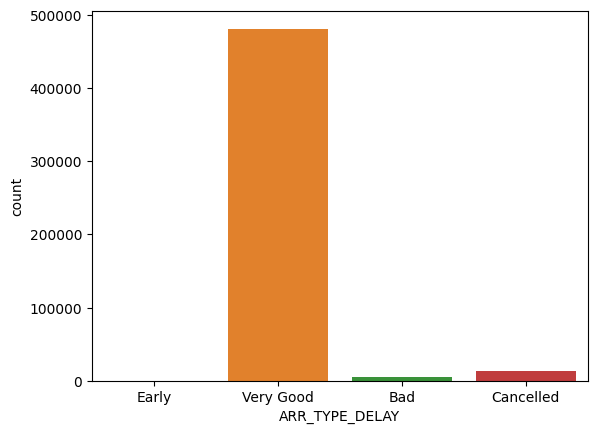

In [25]:
sns.countplot(df[:500000], x = 'ARR_TYPE_DELAY') 

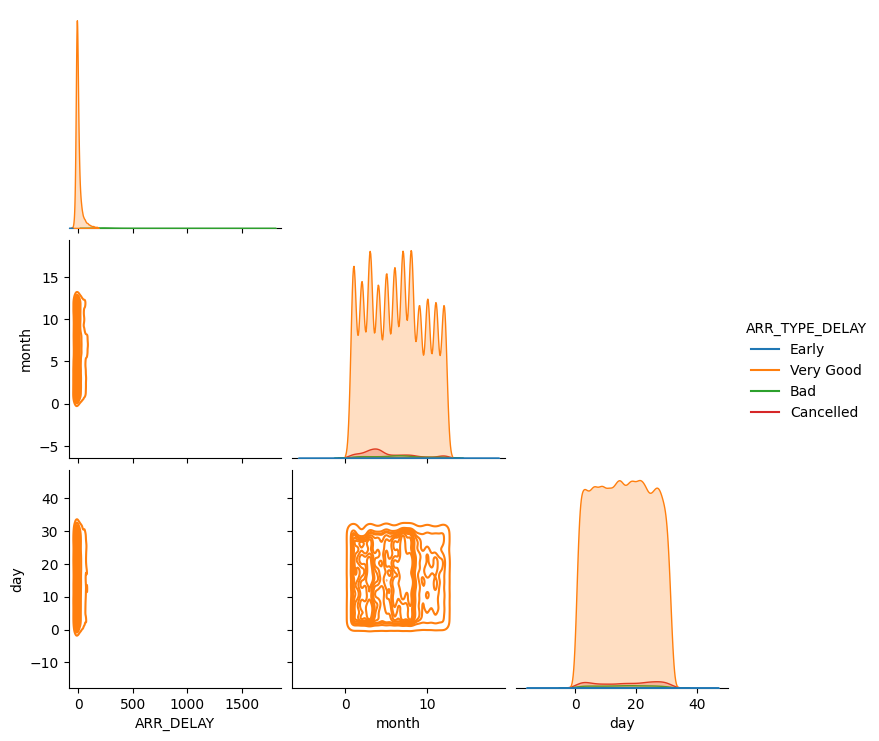

In [15]:
# sns.pairplot(df[:100000] , hue = 'ARR_TYPE_DELAY' , corner =True, kind= 'kde')

In [17]:
df[df['AIRLINE_CODE'] == 'WN']['AIRLINE'].unique()

array(['Southwest Airlines Co.'], dtype=object)

In [ ]:
df_ohe = pd.get_dummies(df , columns=['month', 'day' , 'DEP_TIME_BIN' ] )

In [ ]:
df_ohe.head(2)

,AIRLINE,AIRLINE_CODE,ORIGIN,ORIGIN_CITY,DEST,DEST_CITY,ARR_DELAY,ARR_TYPE_DELAY,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,day_10,day_11,day_12,day_13,day_14,day_15,day_16,day_17,day_18,day_19,day_20,day_21,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31,DEP_TIME_BIN_Early Afternoon 12-15,DEP_TIME_BIN_Early Evening 21-00,DEP_TIME_BIN_Early Morning 05-08,DEP_TIME_BIN_Evening 00-01,DEP_TIME_BIN_Late Afternoon 18-21,DEP_TIME_BIN_Late Morning 08-12,DEP_TIME_BIN_Night 01-05
0,United Air Lines Inc.,UA,FLL,"Fort Lauderdale, FL",EWR,"Newark, NJ",-14.0,Very Good,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
1,Delta Air Lines Inc.,DL,MSP,"Minneapolis, MN",SEA,"Seattle, WA",-5.0,Very Good,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False


> Scenario #1 : One airline company as the output

- Airline prediction

In [ ]:
# input and output splitting

y_airline = df_ohe[[ 'AIRLINE_CODE' ]]
X_airline = df_ohe.drop( [ 'AIRLINE' , 'ARR_DELAY', 'ORIGIN_CITY' , 'DEST_CITY' , 'AIRLINE_CODE' , 'ARR_TYPE_DELAY' ] , axis = 1 ) 

print('\nIntermdiate Inputs :\n')
display(X_airline.head(10))



Intermdiate Inputs :



,ORIGIN,DEST,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,day_10,day_11,day_12,day_13,day_14,day_15,day_16,day_17,day_18,day_19,day_20,day_21,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31,DEP_TIME_BIN_Early Afternoon 12-15,DEP_TIME_BIN_Early Evening 21-00,DEP_TIME_BIN_Early Morning 05-08,DEP_TIME_BIN_Evening 00-01,DEP_TIME_BIN_Late Afternoon 18-21,DEP_TIME_BIN_Late Morning 08-12,DEP_TIME_BIN_Night 01-05
0,FLL,EWR,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
1,MSP,SEA,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
2,DEN,MSP,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
3,MSP,SFO,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
4,MCO,DFW,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
5,DAL,OKC,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False
6,DCA,BOS,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
7,HSV,DCA,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
8,IAH,LAX,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False
9,SEA,FAI,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False


In [ ]:
# OHE of categorical features
nw_y = y_airline.copy()
nw_X = pd.get_dummies(X_airline)

print('Final Inputs :\n')
display(nw_X.head())

print('\nOutputs :\n')
display(nw_y.head())

Final Inputs :



,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,day_10,day_11,day_12,day_13,day_14,day_15,day_16,day_17,day_18,day_19,day_20,day_21,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31,DEP_TIME_BIN_Early Afternoon 12-15,DEP_TIME_BIN_Early Evening 21-00,DEP_TIME_BIN_Early Morning 05-08,DEP_TIME_BIN_Evening 00-01,DEP_TIME_BIN_Late Afternoon 18-21,DEP_TIME_BIN_Late Morning 08-12,DEP_TIME_BIN_Night 01-05,ORIGIN_ABE,ORIGIN_ABI,ORIGIN_ABQ,ORIGIN_ABR,ORIGIN_ABY,ORIGIN_ACK,ORIGIN_ACT,ORIGIN_ACV,ORIGIN_ACY,ORIGIN_ADK,ORIGIN_ADQ,ORIGIN_AEX,ORIGIN_AGS,ORIGIN_AKN,ORIGIN_ALB,ORIGIN_ALO,ORIGIN_ALS,ORIGIN_ALW,ORIGIN_AMA,ORIGIN_ANC,ORIGIN_APN,ORIGIN_ART,ORIGIN_ASE,ORIGIN_ATL,ORIGIN_ATW,ORIGIN_ATY,ORIGIN_AUS,ORIGIN_AVL,ORIGIN_AVP,ORIGIN_AZA,ORIGIN_AZO,ORIGIN_BDL,ORIGIN_BET,ORIGIN_BFF,ORIGIN_BFL,ORIGIN_BFM,ORIGIN_BGM,ORIGIN_BGR,ORIGIN_BHM,ORIGIN_BIH,ORIGIN_BIL,ORIGIN_BIS,ORIGIN_BJI,ORIGIN_BKG,ORIGIN_BLI,ORIGIN_BLV,ORIGIN_BMI,ORIGIN_BNA,ORIGIN_BOI,ORIGIN_BOS,ORIGIN_BPT,ORIGIN_BQK,ORIGIN_BQN,ORIGIN_BRD,ORIGIN_BRO,ORIGIN_BRW,ORIGIN_BTM,ORIGIN_BTR,ORIGIN_BTV,ORIGIN_BUF,ORIGIN_BUR,ORIGIN_BWI,ORIGIN_BZN,ORIGIN_CAE,ORIGIN_CAK,ORIGIN_CDB,ORIGIN_CDC,ORIGIN_CDV,ORIGIN_CGI,ORIGIN_CHA,ORIGIN_CHO,ORIGIN_CHS,ORIGIN_CID,ORIGIN_CIU,ORIGIN_CKB,ORIGIN_CLE,ORIGIN_CLL,ORIGIN_CLT,ORIGIN_CMH,ORIGIN_CMI,ORIGIN_CMX,ORIGIN_CNY,ORIGIN_COD,ORIGIN_COS,ORIGIN_COU,ORIGIN_CPR,ORIGIN_CRP,ORIGIN_CRW,ORIGIN_CSG,ORIGIN_CVG,ORIGIN_CWA,ORIGIN_CYS,ORIGIN_DAB,ORIGIN_DAL,ORIGIN_DAY,ORIGIN_DBQ,ORIGIN_DCA,ORIGIN_DDC,ORIGIN_DEC,ORIGIN_DEN,ORIGIN_DFW,ORIGIN_DHN,ORIGIN_DIK,ORIGIN_DLG,ORIGIN_DLH,ORIGIN_DRO,ORIGIN_DRT,ORIGIN_DSM,ORIGIN_DTW,ORIGIN_DVL,ORIGIN_EAR,ORIGIN_EAT,ORIGIN_EAU,ORIGIN_ECP,ORIGIN_EGE,ORIGIN_EKO,ORIGIN_ELM,ORIGIN_ELP,ORIGIN_ERI,ORIGIN_ESC,ORIGIN_EUG,ORIGIN_EVV,ORIGIN_EWN,ORIGIN_EWR,ORIGIN_EYW,ORIGIN_FAI,ORIGIN_FAR,ORIGIN_FAT,ORIGIN_FAY,ORIGIN_FCA,ORIGIN_FLG,ORIGIN_FLL,ORIGIN_FLO,ORIGIN_FNT,ORIGIN_FOD,ORIGIN_FSD,ORIGIN_FSM,ORIGIN_FWA,ORIGIN_GCC,ORIGIN_GCK,ORIGIN_GEG,ORIGIN_GFK,ORIGIN_GGG,ORIGIN_GJT,ORIGIN_GNV,ORIGIN_GPT,ORIGIN_GRB,ORIGIN_GRI,ORIGIN_GRK,ORIGIN_GRR,ORIGIN_GSO,ORIGIN_GSP,ORIGIN_GST,ORIGIN_GTF,ORIGIN_GTR,ORIGIN_GUC,ORIGIN_GUM,ORIGIN_HDN,ORIGIN_HGR,ORIGIN_HHH,ORIGIN_HIB,ORIGIN_HLN,ORIGIN_HNL,ORIGIN_HOB,ORIGIN_HOU,ORIGIN_HPN,ORIGIN_HRL,ORIGIN_HSV,ORIGIN_HTS,ORIGIN_HVN,ORIGIN_HYA,ORIGIN_HYS,ORIGIN_IAD,ORIGIN_IAG,ORIGIN_IAH,ORIGIN_ICT,ORIGIN_IDA,ORIGIN_ILG,ORIGIN_ILM,ORIGIN_IMT,ORIGIN_IND,ORIGIN_INL,ORIGIN_IPT,ORIGIN_ISN,ORIGIN_ISP,ORIGIN_ITH,ORIGIN_ITO,ORIGIN_JAC,ORIGIN_JAN,ORIGIN_JAX,ORIGIN_JFK,ORIGIN_JLN,ORIGIN_JMS,ORIGIN_JNU,ORIGIN_JST,ORIGIN_KOA,ORIGIN_KTN,ORIGIN_LAN,ORIGIN_LAR,ORIGIN_LAS,ORIGIN_LAW,ORIGIN_LAX,ORIGIN_LBB,ORIGIN_LBE,ORIGIN_LBF,ORIGIN_LBL,ORIGIN_LCH,ORIGIN_LCK,ORIGIN_LEX,ORIGIN_LFT,ORIGIN_LGA,ORIGIN_LGB,ORIGIN_LIH,ORIGIN_LIT,ORIGIN_LNK,ORIGIN_LRD,ORIGIN_LSE,ORIGIN_LWB,ORIGIN_LWS,ORIGIN_LYH,ORIGIN_MAF,ORIGIN_MBS,ORIGIN_MCI,ORIGIN_MCO,ORIGIN_MCW,ORIGIN_MDT,ORIGIN_MDW,ORIGIN_MEI,ORIGIN_MEM,ORIGIN_MFE,ORIGIN_MFR,ORIGIN_MGM,ORIGIN_MHK,ORIGIN_MHT,ORIGIN_MIA,ORIGIN_MKE,ORIGIN_MKG,ORIGIN_MLB,ORIGIN_MLI,ORIGIN_MLU,ORIGIN_MMH,ORIGIN_MOB,ORIGIN_MOT,ORIGIN_MQT,ORIGIN_MRY,ORIGIN_MSN,ORIGIN_MSO,ORIGIN_MSP,ORIGIN_MSY,ORIGIN_MTJ,ORIGIN_MVY,ORIGIN_MYR,ORIGIN_OAJ,ORIGIN_OAK,ORIGIN_OGD,ORIGIN_OGG,ORIGIN_OGS,ORIGIN_OKC,ORIGIN_OMA,ORIGIN_OME,ORIGIN_ONT,ORIGIN_ORD,ORIGIN_ORF,ORIGIN_ORH,ORIGIN_OTH,ORIGIN_OTZ,ORIGIN_OWB,ORIGIN_PAE,ORIGIN_PAH,ORIGIN_PBG,ORIGIN_PBI,ORIGIN_PDX,ORIGIN_PGD,ORIGIN_PGV,ORIGIN_PHF,ORIGIN_PHL,ORIGIN_PHX,ORIGIN_PIA,ORIGIN_PIB,ORIGIN_PIE,ORIGIN_PIH,ORIGIN_PIR,ORIGIN_PIT,ORIGIN_PLN,ORIGIN_PNS,ORIGIN_PPG,ORIGIN_PRC,ORIGIN_PSC,ORIGIN_PSE,ORIGIN_PSG,ORIGIN_PSM,ORIGIN_PSP,ORIGIN_PUB,ORIGIN_PUW,ORIGIN_PVD,ORIGIN_PVU,ORIGIN_PWM,ORIGIN_RAP,ORIGIN_RDD,ORIGIN_RDM,ORIGIN_RDU,ORIGIN_RFD,ORIGIN_RHI,ORIGIN_RIC,ORIGIN_RIW,ORIGIN_RKS,ORIGIN_RNO,ORIGIN_ROA,ORIGIN_ROC,ORIGIN_ROW,ORIGIN_RST,ORIGIN_RSW,ORIGIN_SAF,ORIGIN_SAN,ORIGIN_SAT,ORIGIN_S


Outputs :



,AIRLINE_CODE
0,UA
1,DL
2,UA
3,DL
4,NK


In [ ]:
nw_X.shape

(2992942, 810)

In [ ]:
nw_y.shape

(2992942, 1)

In [ ]:
X_train_air, X_test_air, y_train_air, y_test_air = train_test_split( nw_X, nw_y , test_size=0.10, random_state=42 , shuffle = True  , stratify= nw_y['AIRLINE_CODE']) 

In [ ]:
# proportion of class within the output - train

display((y_train_air.value_counts()) / len(y_train_air))

AIRLINE_CODE
WN              0.192230
DL              0.131796
AA              0.127675
OO              0.114513
UA              0.084801
YX              0.047710
MQ              0.040410
B6              0.037584
9E              0.037502
OH              0.035679
AS              0.033488
NK              0.031912
YV              0.021668
F9              0.021509
G4              0.017562
HA              0.010720
QX              0.006887
EV              0.006353
Name: count, dtype: float64

In [ ]:
# proportion of class within the output - test 

display((y_test_air.value_counts()) / len(y_test_air))

AIRLINE_CODE
WN              0.192232
DL              0.131796
AA              0.127677
OO              0.114512
UA              0.084803
YX              0.047709
MQ              0.040408
B6              0.037585
9E              0.037501
OH              0.035677
AS              0.033489
NK              0.031912
YV              0.021668
F9              0.021511
G4              0.017561
HA              0.010722
QX              0.006886
EV              0.006352
Name: count, dtype: float64

In [ ]:
X_train_air.shape

(2693647, 810)

In [ ]:
X_test_air.shape

(299295, 810)

In [ ]:
## Airline baseline
n = 500

svm_airline = SVC(decision_function_shape = 'ovo',random_state=42)

In [1]:
# for i in list(gen_even_slices(len(X_train_air), n)):
#   print(f"From - {i}  : Done !! ")
#   svm_airline.fit(X_train_air[i], y_train_air[i])

# print(f"Train  -- Ended !!")

In [ ]:
y_hat1 = svm_airline.predict(X_test_air[0:n])

sc1 = f1_score(y_test_air[0:n], y_hat1, average='macro')
sc2 = recall_score(y_test_air[0:n], y_hat1, average='macro')
sc3 = accuracy_score(y_test_air[0:n], y_hat1)
sc4 = precision_score(y_test_air[0:n], y_hat1, average='macro')

score_svm = {
  'f1_score' : sc1  ,
  'recall_score' : sc2,
  'accuracy_score' : sc3,
  'precision_score' :sc4
}
print(f"{score_svm}")

In [ ]:
# Predictions
m = 10
hat = svm_airline.predict(X_test_air[0:m])

out = {
      'Ground Truth' : list(y_test_air['AIRLINE_CODE'][0:m] ) ,
      'Prediction' : list(hat)
  }

display(pd.DataFrame(out))


,Ground Truth,Prediction
0,DL,WN
1,F9,WN
2,AA,WN
3,WN,WN
4,OO,WN
5,UA,WN
6,OO,WN
7,WN,OO
8,YX,OO
9,MQ,WN


**Baseline Results** :

1. ovr - macro : 

'f1_score': 0.04, 'recall_score': 0.06, 'accuracy_score': 0.19, 'precision_score': 0.04

<!-- 2. ovo - macro :

'f1_score': 0.32, 'recall_score': 0.33, 'accuracy_score': 0.962, 'precision_score': 0.32 -->

- Delay

In [ ]:
# input and output splitting

y_delay = df_ohe[[ 'ARR_TYPE_DELAY']]
X_delay = df_ohe.drop( [ 'AIRLINE' , 'ARR_DELAY', 'ORIGIN_CITY' , 'DEST_CITY' , 'AIRLINE_CODE' , 'ARR_TYPE_DELAY' ] , axis = 1 )

print('\nIntermdiate Inputs :\n')
display(X_airline.head(10))


Intermdiate Inputs :



,ORIGIN,DEST,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,day_10,day_11,day_12,day_13,day_14,day_15,day_16,day_17,day_18,day_19,day_20,day_21,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31,DEP_TIME_BIN_Early Afternoon 12-15,DEP_TIME_BIN_Early Evening 21-00,DEP_TIME_BIN_Early Morning 05-08,DEP_TIME_BIN_Evening 00-01,DEP_TIME_BIN_Late Afternoon 18-21,DEP_TIME_BIN_Late Morning 08-12,DEP_TIME_BIN_Night 01-05
0,FLL,EWR,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
1,MSP,SEA,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
2,DEN,MSP,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
3,MSP,SFO,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
4,MCO,DFW,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
5,DAL,OKC,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False
6,DCA,BOS,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
7,HSV,DCA,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
8,IAH,LAX,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False
9,SEA,FAI,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False


In [ ]:
# OHE of categorical features
nw_y = y_delay.copy()
nw_X = pd.get_dummies(X_delay)

print('Final Inputs :\n')
display(nw_X.head())

print('\nOutputs :\n')
display(nw_y.head())

Final Inputs :



,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,day_10,day_11,day_12,day_13,day_14,day_15,day_16,day_17,day_18,day_19,day_20,day_21,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31,DEP_TIME_BIN_Early Afternoon 12-15,DEP_TIME_BIN_Early Evening 21-00,DEP_TIME_BIN_Early Morning 05-08,DEP_TIME_BIN_Evening 00-01,DEP_TIME_BIN_Late Afternoon 18-21,DEP_TIME_BIN_Late Morning 08-12,DEP_TIME_BIN_Night 01-05,ORIGIN_ABE,ORIGIN_ABI,ORIGIN_ABQ,ORIGIN_ABR,ORIGIN_ABY,ORIGIN_ACK,ORIGIN_ACT,ORIGIN_ACV,ORIGIN_ACY,ORIGIN_ADK,ORIGIN_ADQ,ORIGIN_AEX,ORIGIN_AGS,ORIGIN_AKN,ORIGIN_ALB,ORIGIN_ALO,ORIGIN_ALS,ORIGIN_ALW,ORIGIN_AMA,ORIGIN_ANC,ORIGIN_APN,ORIGIN_ART,ORIGIN_ASE,ORIGIN_ATL,ORIGIN_ATW,ORIGIN_ATY,ORIGIN_AUS,ORIGIN_AVL,ORIGIN_AVP,ORIGIN_AZA,ORIGIN_AZO,ORIGIN_BDL,ORIGIN_BET,ORIGIN_BFF,ORIGIN_BFL,ORIGIN_BFM,ORIGIN_BGM,ORIGIN_BGR,ORIGIN_BHM,ORIGIN_BIH,ORIGIN_BIL,ORIGIN_BIS,ORIGIN_BJI,ORIGIN_BKG,ORIGIN_BLI,ORIGIN_BLV,ORIGIN_BMI,ORIGIN_BNA,ORIGIN_BOI,ORIGIN_BOS,ORIGIN_BPT,ORIGIN_BQK,ORIGIN_BQN,ORIGIN_BRD,ORIGIN_BRO,ORIGIN_BRW,ORIGIN_BTM,ORIGIN_BTR,ORIGIN_BTV,ORIGIN_BUF,ORIGIN_BUR,ORIGIN_BWI,ORIGIN_BZN,ORIGIN_CAE,ORIGIN_CAK,ORIGIN_CDB,ORIGIN_CDC,ORIGIN_CDV,ORIGIN_CGI,ORIGIN_CHA,ORIGIN_CHO,ORIGIN_CHS,ORIGIN_CID,ORIGIN_CIU,ORIGIN_CKB,ORIGIN_CLE,ORIGIN_CLL,ORIGIN_CLT,ORIGIN_CMH,ORIGIN_CMI,ORIGIN_CMX,ORIGIN_CNY,ORIGIN_COD,ORIGIN_COS,ORIGIN_COU,ORIGIN_CPR,ORIGIN_CRP,ORIGIN_CRW,ORIGIN_CSG,ORIGIN_CVG,ORIGIN_CWA,ORIGIN_CYS,ORIGIN_DAB,ORIGIN_DAL,ORIGIN_DAY,ORIGIN_DBQ,ORIGIN_DCA,ORIGIN_DDC,ORIGIN_DEC,ORIGIN_DEN,ORIGIN_DFW,ORIGIN_DHN,ORIGIN_DIK,ORIGIN_DLG,ORIGIN_DLH,ORIGIN_DRO,ORIGIN_DRT,ORIGIN_DSM,ORIGIN_DTW,ORIGIN_DVL,ORIGIN_EAR,ORIGIN_EAT,ORIGIN_EAU,ORIGIN_ECP,ORIGIN_EGE,ORIGIN_EKO,ORIGIN_ELM,ORIGIN_ELP,ORIGIN_ERI,ORIGIN_ESC,ORIGIN_EUG,ORIGIN_EVV,ORIGIN_EWN,ORIGIN_EWR,ORIGIN_EYW,ORIGIN_FAI,ORIGIN_FAR,ORIGIN_FAT,ORIGIN_FAY,ORIGIN_FCA,ORIGIN_FLG,ORIGIN_FLL,ORIGIN_FLO,ORIGIN_FNT,ORIGIN_FOD,ORIGIN_FSD,ORIGIN_FSM,ORIGIN_FWA,ORIGIN_GCC,ORIGIN_GCK,ORIGIN_GEG,ORIGIN_GFK,ORIGIN_GGG,ORIGIN_GJT,ORIGIN_GNV,ORIGIN_GPT,ORIGIN_GRB,ORIGIN_GRI,ORIGIN_GRK,ORIGIN_GRR,ORIGIN_GSO,ORIGIN_GSP,ORIGIN_GST,ORIGIN_GTF,ORIGIN_GTR,ORIGIN_GUC,ORIGIN_GUM,ORIGIN_HDN,ORIGIN_HGR,ORIGIN_HHH,ORIGIN_HIB,ORIGIN_HLN,ORIGIN_HNL,ORIGIN_HOB,ORIGIN_HOU,ORIGIN_HPN,ORIGIN_HRL,ORIGIN_HSV,ORIGIN_HTS,ORIGIN_HVN,ORIGIN_HYA,ORIGIN_HYS,ORIGIN_IAD,ORIGIN_IAG,ORIGIN_IAH,ORIGIN_ICT,ORIGIN_IDA,ORIGIN_ILG,ORIGIN_ILM,ORIGIN_IMT,ORIGIN_IND,ORIGIN_INL,ORIGIN_IPT,ORIGIN_ISN,ORIGIN_ISP,ORIGIN_ITH,ORIGIN_ITO,ORIGIN_JAC,ORIGIN_JAN,ORIGIN_JAX,ORIGIN_JFK,ORIGIN_JLN,ORIGIN_JMS,ORIGIN_JNU,ORIGIN_JST,ORIGIN_KOA,ORIGIN_KTN,ORIGIN_LAN,ORIGIN_LAR,ORIGIN_LAS,ORIGIN_LAW,ORIGIN_LAX,ORIGIN_LBB,ORIGIN_LBE,ORIGIN_LBF,ORIGIN_LBL,ORIGIN_LCH,ORIGIN_LCK,ORIGIN_LEX,ORIGIN_LFT,ORIGIN_LGA,ORIGIN_LGB,ORIGIN_LIH,ORIGIN_LIT,ORIGIN_LNK,ORIGIN_LRD,ORIGIN_LSE,ORIGIN_LWB,ORIGIN_LWS,ORIGIN_LYH,ORIGIN_MAF,ORIGIN_MBS,ORIGIN_MCI,ORIGIN_MCO,ORIGIN_MCW,ORIGIN_MDT,ORIGIN_MDW,ORIGIN_MEI,ORIGIN_MEM,ORIGIN_MFE,ORIGIN_MFR,ORIGIN_MGM,ORIGIN_MHK,ORIGIN_MHT,ORIGIN_MIA,ORIGIN_MKE,ORIGIN_MKG,ORIGIN_MLB,ORIGIN_MLI,ORIGIN_MLU,ORIGIN_MMH,ORIGIN_MOB,ORIGIN_MOT,ORIGIN_MQT,ORIGIN_MRY,ORIGIN_MSN,ORIGIN_MSO,ORIGIN_MSP,ORIGIN_MSY,ORIGIN_MTJ,ORIGIN_MVY,ORIGIN_MYR,ORIGIN_OAJ,ORIGIN_OAK,ORIGIN_OGD,ORIGIN_OGG,ORIGIN_OGS,ORIGIN_OKC,ORIGIN_OMA,ORIGIN_OME,ORIGIN_ONT,ORIGIN_ORD,ORIGIN_ORF,ORIGIN_ORH,ORIGIN_OTH,ORIGIN_OTZ,ORIGIN_OWB,ORIGIN_PAE,ORIGIN_PAH,ORIGIN_PBG,ORIGIN_PBI,ORIGIN_PDX,ORIGIN_PGD,ORIGIN_PGV,ORIGIN_PHF,ORIGIN_PHL,ORIGIN_PHX,ORIGIN_PIA,ORIGIN_PIB,ORIGIN_PIE,ORIGIN_PIH,ORIGIN_PIR,ORIGIN_PIT,ORIGIN_PLN,ORIGIN_PNS,ORIGIN_PPG,ORIGIN_PRC,ORIGIN_PSC,ORIGIN_PSE,ORIGIN_PSG,ORIGIN_PSM,ORIGIN_PSP,ORIGIN_PUB,ORIGIN_PUW,ORIGIN_PVD,ORIGIN_PVU,ORIGIN_PWM,ORIGIN_RAP,ORIGIN_RDD,ORIGIN_RDM,ORIGIN_RDU,ORIGIN_RFD,ORIGIN_RHI,ORIGIN_RIC,ORIGIN_RIW,ORIGIN_RKS,ORIGIN_RNO,ORIGIN_ROA,ORIGIN_ROC,ORIGIN_ROW,ORIGIN_RST,ORIGIN_RSW,ORIGIN_SAF,ORIGIN_SAN,ORIGIN_SAT,ORIGIN_S


Outputs :



,ARR_TYPE_DELAY
0,Very Good
1,Very Good
2,Very Good
3,Very Good
4,Very Good


In [ ]:
X_train_del, X_test_del, y_train_del, y_test_del = train_test_split( nw_X, nw_y , test_size=0.10, random_state=42 , shuffle = True  , stratify= nw_y['ARR_TYPE_DELAY']) 

In [ ]:
# proportion of class within the output - train

display((y_train_del.value_counts()) / len(y_train_del))

AIRLINE_CODE
WN              0.192230
DL              0.131796
AA              0.127675
OO              0.114513
UA              0.084801
YX              0.047710
MQ              0.040410
B6              0.037584
9E              0.037502
OH              0.035679
AS              0.033488
NK              0.031912
YV              0.021668
F9              0.021509
G4              0.017562
HA              0.010720
QX              0.006887
EV              0.006353
Name: count, dtype: float64

In [ ]:
# proportion of class within the output - test 

display((y_test_del.value_counts()) / len(y_test_del))

AIRLINE_CODE
WN              0.190637
DL              0.133228
AA              0.127445
OO              0.115027
UA              0.085232
YX              0.047431
MQ              0.040296
9E              0.037689
B6              0.037600
OH              0.035536
AS              0.033747
NK              0.031971
F9              0.021507
YV              0.021452
G4              0.017236
HA              0.010858
QX              0.006940
EV              0.006170
Name: count, dtype: float64

In [ ]:
X_train_del.shape

(2693647, 810)

In [ ]:
X_test_del.shape

(299295, 810)

In [ ]:
## Airline baseline

svm_delay = SVC(decision_function_shape = 'ovo',random_state=42)

In [ ]:
for i in list(gen_even_slices(len(X_train_del), n)):
#   print(f"From - {i[0]} to - {i[1]} : Done !! ")
  svm_delay.fit(X_train_del[i], y_train_del[i])

print(f"Train  -- Ended !!")

In [ ]:
y_hat1 = svm_delay.predict(X_test_del[0:n])

sc1 = f1_score(y_test_del[0:n], y_hat1, average='macro')
sc2 = recall_score(y_test_del[0:n], y_hat1, average='macro')
sc3 = accuracy_score(y_test_del[0:n], y_hat1)
sc4 = precision_score(y_test_del[0:n], y_hat1, average='macro')

score_svm_del = {
  'f1_score' : sc1  ,
  'recall_score' : sc2,
  'accuracy_score' : sc3,
  'precision_score' :sc4
}
print(f"{score_svm_del}")

In [ ]:
# Predictions
m = 10
hat = svm_delay.predict(X_test_del[0:m])

out = {
      'Ground Truth' : list(y_test_del['AIRLINE_CODE'][0:m] ) ,
      'Prediction' : list(hat)
  }

display(pd.DataFrame(out))


,Ground Truth,Prediction
0,DL,WN
1,F9,WN
2,AA,WN
3,WN,WN
4,OO,WN
5,UA,WN
6,OO,WN
7,WN,OO
8,YX,OO
9,MQ,WN


## **Data augmentation**

Smote

## **Features engineering**

## **Advanced models**

Bagginng

Boosting

Stacking

## **Conclusion and Model Choice**